In [151]:
# Basic
import numpy as np
import pandas as pd
import pandas_profiling as pdp
import matplotlib.pyplot as plt
import seaborn as sns

# Common Tools
from sklearn.preprocessing import LabelEncoder
from collections import Counter

#Algorithms
from sklearn import ensemble, tree, svm, naive_bayes, neighbors, linear_model, gaussian_process, neural_network
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

# Model
from sklearn.metrics import accuracy_score, f1_score, auc, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
#from sklearn.ensemble import VotingClassifier

#Configure Defaults
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

df_train = pd.read_csv(r'\train.csv')
df_test = pd.read_csv(r'\titanic\test.csv')
#pprint.pprint(df_train)
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [272]:
df_train.describe(include='O')

,Name,Sex,Ticket,Cabin,Embarked
count,882,882,882,196,880
unique,882,2,678,144,3
top,"Ayoub, Miss. Banoura",male,1601,G6,S
freq,1,573,7,4,640


In [277]:
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.623188
1,2,0.472826
2,3,0.242363


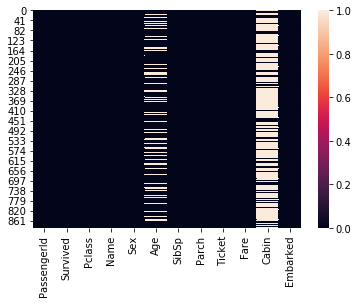

In [14]:
sns.heatmap(df_train.isnull())

In [15]:
def kesson_table(df):
    null_count = df.isnull().sum()
    loss_ratio = 100 * null_count/len(df)
    data = pd.concat([null_count, loss_ratio], axis=1)
    return data
kesson_table(df_train)

,0,1
PassengerId,0,0.000000
Survived,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
Age,177,19.865320
SibSp,0,0.000000
Parch,0,0.000000
Ticket,0,0.000000
Fare,0,0.000000


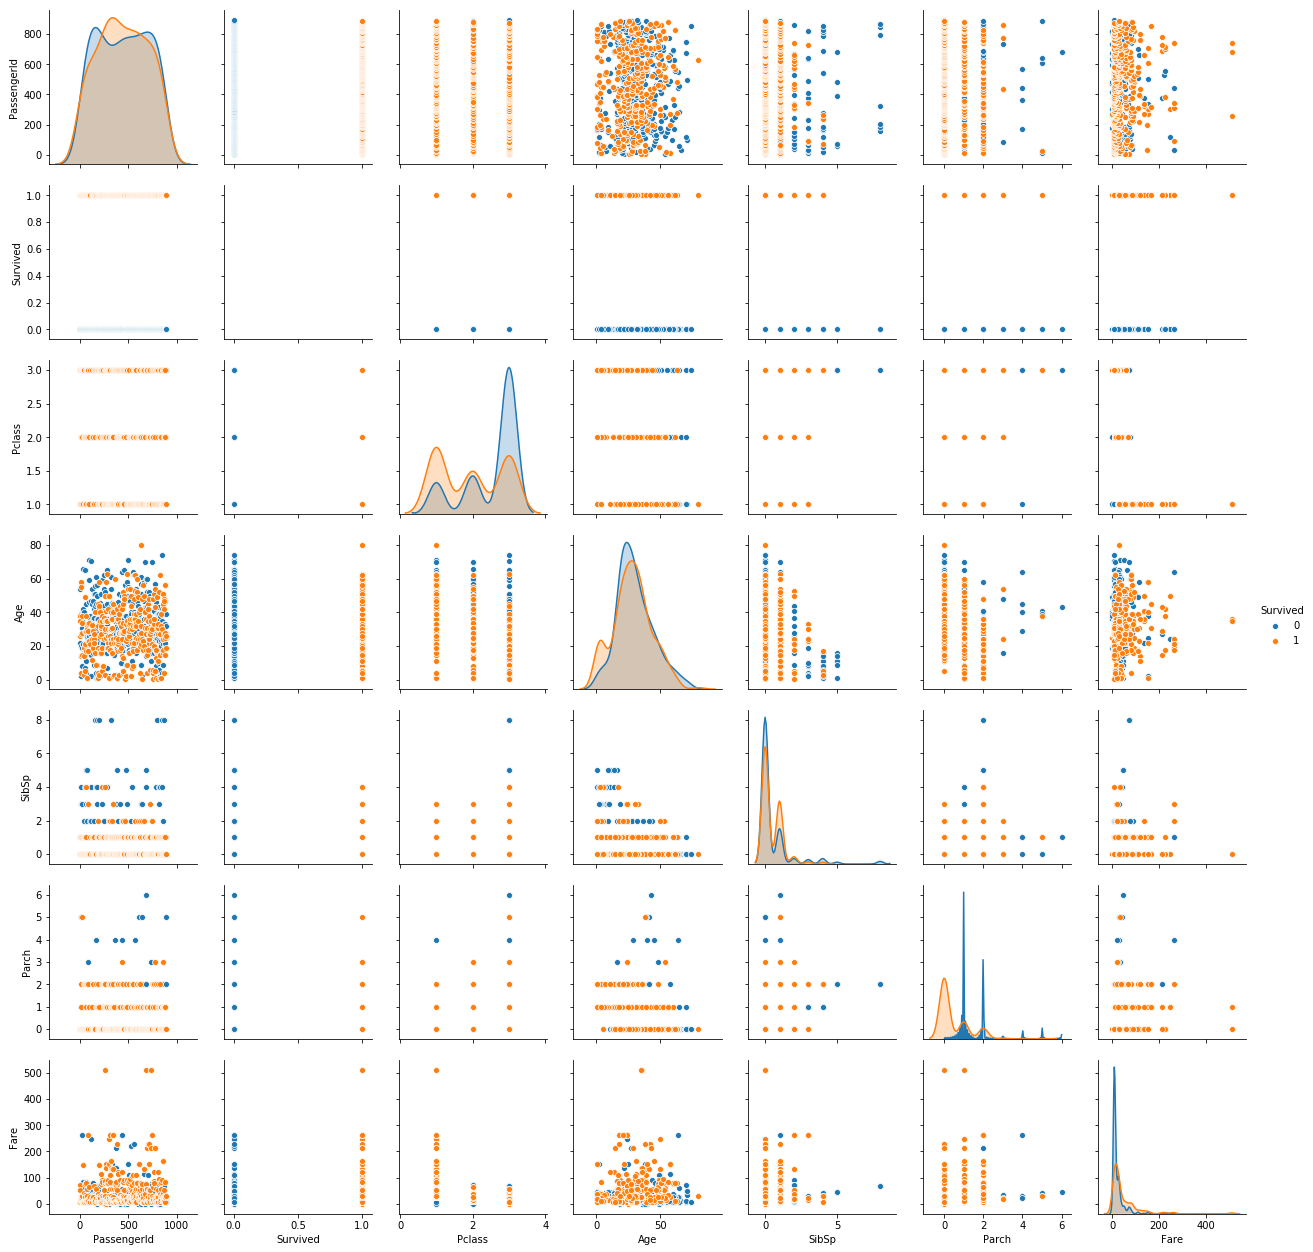

In [16]:
sns.pairplot(df_train, hue='Survived')

## Survivedの確認

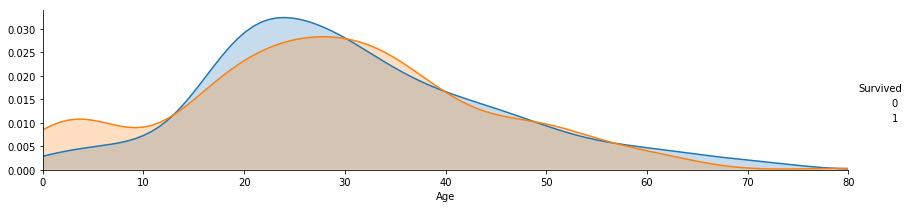

In [17]:
a = sns.FacetGrid(df_train, hue='Survived', aspect=4)
a.map(sns.kdeplot, 'Age',
      shade=True)
a.set(xlim=(0, df_train['Age'].max()))
a.add_legend({0:'dead', 1:'survive'})

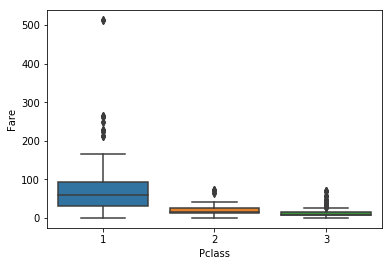

In [18]:
sns.boxplot(x='Pclass', y='Fare', data=df_train)

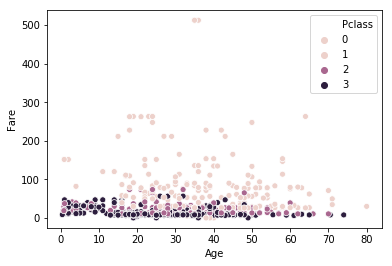

In [19]:
sns.scatterplot(x='Age', y='Fare', hue='Pclass', data=df_train)

In [20]:
df_train.groupby(['Parch'])['Survived'].count()

Parch
0    678
1    118
2     80
3      5
4      4
5      5
6      1
Name: Survived, dtype: int64

In [21]:
df_train.groupby(['SibSp'])['Survived'].count()

SibSp
0    608
1    209
2     28
3     16
4     18
5      5
8      7
Name: Survived, dtype: int64

## Data Wrangling

In [152]:
q = df_train['Fare'].quantile(0.99)
q

249.00622000000033

In [153]:
df_train = df_train[df_train['Fare'] < q]
df_train.max()

PassengerId                            891
Survived                                 1
Pclass                                   3
Name           van Melkebeke, Mr. Philemon
Sex                                   male
Age                                     80
SibSp                                    8
Parch                                    6
Ticket                           WE/P 5735
Fare                               247.521
dtype: object

In [154]:
Id = df_test['PassengerId']
Id.shape

(418,)

In [155]:
split = len(df_train)
split

882

In [156]:
data = pd.concat(objs=[df_train, df_test], axis=0).reset_index(drop=True)

In [157]:
data.drop('PassengerId', axis=1, inplace=True)

In [158]:
data.shape

(1300, 11)

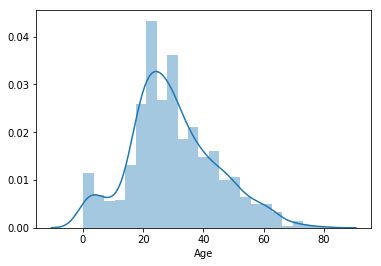

In [29]:
sns.distplot(data['Age'].dropna())

In [159]:
median = data['Age'].median()
std = data['Age'].std()
is_null = data['Age'].isnull().sum()
rand_age = np.random.randint(median - std, median + std, size=is_null)
age_slice = data['Age']
age_slice[np.isnan(age_slice)] = rand_age
data['Age'] = age_slice
data['Age'] = data['Age'].astype(int)
data['Age'].isnull().sum()

0

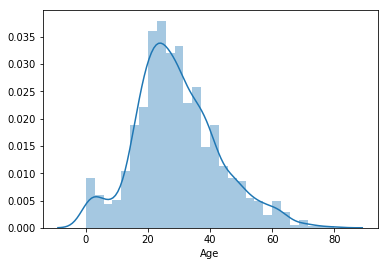

In [31]:
sns.distplot(data['Age'])

In [160]:
print(data.Embarked.mode()[0])
data.Embarked.fillna(data.Embarked.mode()[0], inplace=True)#[0]がないと
data.Embarked.isnull().sum()

S


0

In [172]:
data.isnull().sum()

Age            0
Cabin       1013
Embarked       0
Fare           1
Name           0
Parch          0
Pclass         0
Sex            0
SibSp          0
Survived     418
Ticket         0
dtype: int64

In [161]:
data.Fare.fillna(data.Fare.mean(),inplace=True)
data.Fare.isnull().sum()

0

In [162]:
print(data['Cabin'].notnull()[:5])
data['CabinBool'] = data['Cabin'].notnull().astype('int')
#data.CabinBool

0    False
1     True
2    False
3     True
4    False
Name: Cabin, dtype: bool


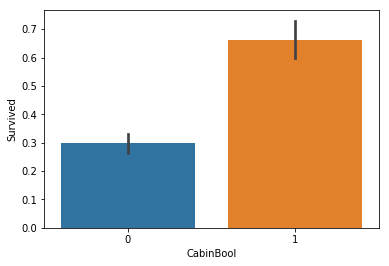

In [37]:
sns.barplot(x='CabinBool', y='Survived' ,data=data)

In [163]:
data['Deck'] = data.Cabin.str.extract('([a-zA-Z]+)',expand=False)
data[['Cabin', 'Deck']].sample(10)#非復元抽出

,Cabin,Deck
881,NaN,NaN
832,NaN,NaN
379,NaN,NaN
304,C65,C
478,B49,B
626,B50,B
830,C47,C
1011,NaN,NaN
491,NaN,NaN
568,NaN,NaN


In [164]:
data['Deck'] = data['Deck'].fillna('Z')
data = data.drop('Cabin', axis=1)
data.head()

,Age,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,CabinBool,Deck
0,22,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0.0,A/5 21171,0,Z
1,38,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1.0,PC 17599,1,C
2,26,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1.0,STON/O2. 3101282,0,Z
3,35,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0,113803,1,C
4,35,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,0.0,373450,0,Z


In [43]:
data['Deck'].sample(10)

904    Z
978    C
386    Z
314    C
363    Z
902    Z
169    Z
172    A
846    Z
398    Z
Name: Deck, dtype: object

In [165]:
data['Familysize'] = data['SibSp'] + data['Parch']

In [166]:
data['IsAlone'] = 1

In [167]:
data.IsAlone.shape

(1300,)

In [168]:
data['IsAlone'].loc[data['Familysize'] > 0] = 0

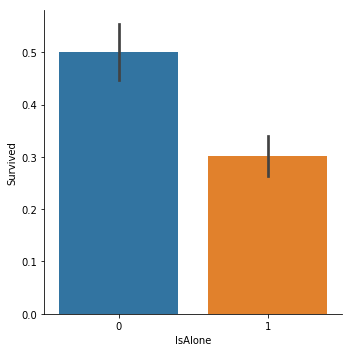

In [169]:
sns.factorplot(x='IsAlone', y='Survived', data=data, kind='bar')

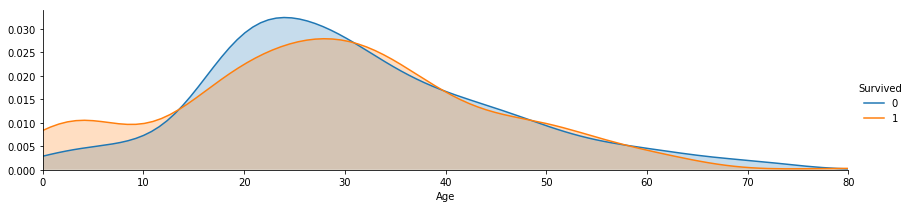

In [170]:
a = sns.FacetGrid(df_train, hue='Survived', aspect=4)
a.map(sns.kdeplot, 'Age', shade='True')
a.set(xlim=(0, df_train['Age'].max()))
a.add_legend()

In [171]:
bins = [-1, 13, 31, 60, 85]
labels = ['child', 'Young Adult', 'Adult', 'Senior']
data['AgeBin'] = pd.cut(data['Age'], bins, labels=labels).astype(object)
data['AgeBin'][:5]

0    Young Adult
1          Adult
2    Young Adult
3          Adult
4          Adult
Name: AgeBin, dtype: object

In [172]:
data.groupby(['AgeBin'])['Survived'].sum()/data.groupby(['AgeBin'])['Survived'].count()

AgeBin
Adult          0.372308
Senior         0.238095
Young Adult    0.357918
child          0.586667
Name: Survived, dtype: float64

In [173]:
data.groupby(['AgeBin'])['Survived'].count()

AgeBin
Adult          325
Senior          21
Young Adult    461
child           75
Name: Survived, dtype: int64

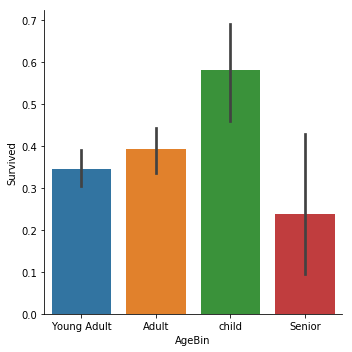

In [63]:
sns.factorplot(x='AgeBin', y='Survived', data=data, kind='bar')

In [174]:
data['IsBaby']=0
data.IsBaby.shape

(1300,)

In [175]:
#data['IsBaby'] = [1 if i <= 5 else 0 for i in data['Age']]
data['IsBaby'].loc[data['Age'] <= 5] = 1

In [176]:
data['Title'] = data.Name.str.extract('([A-Za-z]+)\.', expand=False)
data.groupby(['Title'])['Survived'].count()

Title
Capt          1
Col           2
Countess      1
Don           1
Dona          0
Dr            7
Jonkheer      1
Lady          1
Major         2
Master       40
Miss        177
Mlle          2
Mme           1
Mr          513
Mrs         125
Ms            1
Rev           6
Sir           1
Name: Survived, dtype: int64

In [177]:
data['Title'] = data['Title'].replace(['Capt', 'Col', 'Dr','Don', 'Major', 'Rev', 'Jonkheer', 'Dona'], 'Rare')
data.groupby(['Title'])['Survived'].count()

Title
Countess      1
Lady          1
Master       40
Miss        177
Mlle          2
Mme           1
Mr          513
Mrs         125
Ms            1
Rare         20
Sir           1
Name: Survived, dtype: int64

In [178]:
data['Title'] = data['Title'].replace(['Countess', 'Lady', 'Sir'], 'Royal')
data['Title'] = data['Title'].replace('Mlle', 'Miss')
data['Title'] = data['Title'].replace('Mme', 'Mrs')
data['Title'] = data['Title'].replace('Ms', 'Miss')

In [179]:
data.groupby(['Title'])['Survived'].count()

Title
Master     40
Miss      180
Mr        513
Mrs       126
Rare       20
Royal       3
Name: Survived, dtype: int64

In [180]:
data['Title'] = data['Title'].astype('object')

In [181]:
data[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.694444
2,Mr,0.153996
3,Mrs,0.793651
4,Rare,0.250000
5,Royal,1.000000


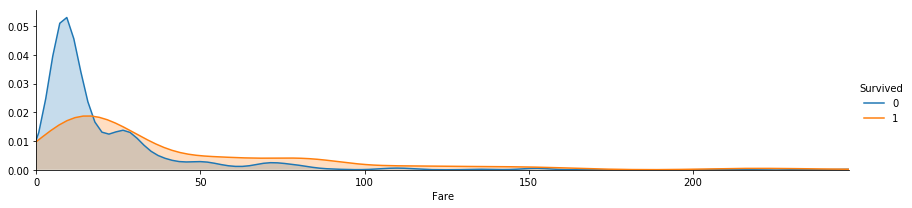

In [182]:
f = sns.FacetGrid(df_train, hue='Survived', aspect=4)
f.map(sns.kdeplot, 'Fare', shade=True)
f.set(xlim=(0, df_train['Fare'].max()))
f.add_legend()

count    882.000000
mean      29.002508
std       36.569302
min        0.000000
25%        7.895800
50%       14.454200
75%       30.500000
max      247.520800
Name: Fare, dtype: float64

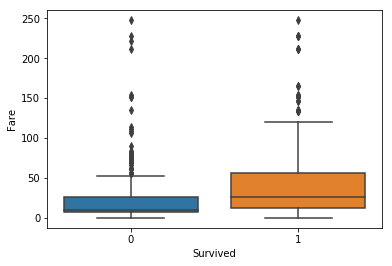

In [122]:
sns.boxplot(x=df_train['Survived'], y=df_train['Fare'])
df_train.Fare.describe()

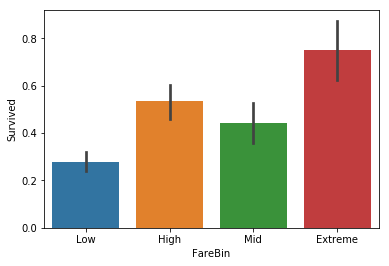

In [190]:
bins = [-np.inf, 20, 30, 110, np.inf]
labels =['Low', 'Mid', 'High', 'Extreme']
data['FareBin'] = pd.cut(data['Fare'], bins, labels=labels).astype('object')
data[['FareBin', 'Survived']].groupby(['FareBin'], as_index=False).mean()
sns.barplot(x=data['FareBin'], y=data['Survived'])

In [191]:
data.columns

Index(['Age', 'Embarked', 'Fare', 'Name', 'Parch', 'Pclass', 'Sex', 'SibSp',
       'Survived', 'Ticket', 'CabinBool', 'Deck', 'Familysize', 'IsAlone',
       'AgeBin', 'IsBaby', 'Title', 'FareBin'],
      dtype='object')

In [192]:
df = data

In [185]:
def correlation_heatmap(df, method):
    _, ax = plt.subplots(figsize=(14,12))
    colormap = sns.diverging_palette(220,10, as_cmap=True)
    
    _ = sns.heatmap(
        df.corr(method=method),
        cmap=colormap,
        square = True,
        annot = True,
        annot_kws={'fontsize':9}
    )    
    plt.title('Correlation Matrix', y=1.05, size=15)

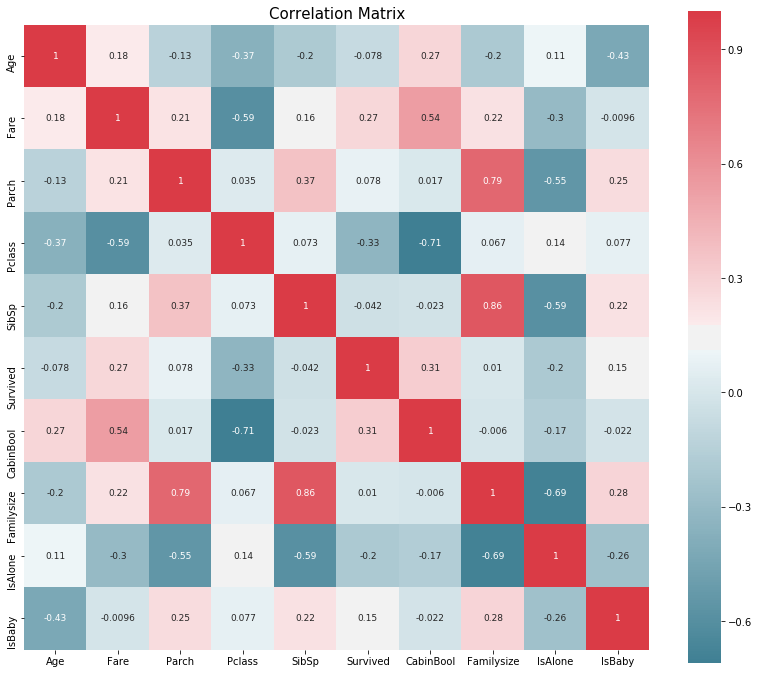

In [186]:
correlation_heatmap(df, 'pearson')

In [195]:
to_drop = ['Age', 'AgeBin', 'SibSp', 'Parch', 'Familysize', 'Title','Embarked']
df = df.drop(to_drop, axis=1, inplace=False)

KeyError: "['Age' 'AgeBin' 'SibSp' 'Parch' 'Familysize' 'Title' 'Embarked'] not found in axis"

In [196]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 11 columns):
Fare         1300 non-null float64
Name         1300 non-null object
Pclass       1300 non-null int64
Sex          1300 non-null object
Survived     882 non-null float64
Ticket       1300 non-null object
CabinBool    1300 non-null int32
Deck         1300 non-null object
IsAlone      1300 non-null int64
IsBaby       1300 non-null int64
FareBin      1300 non-null object
dtypes: float64(2), int32(1), int64(3), object(5)
memory usage: 106.7+ KB


In [197]:
add_drop = ['Fare', 'Name', 'Ticket']
df = df.drop(add_drop, axis=1, inplace=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 8 columns):
Pclass       1300 non-null int64
Sex          1300 non-null object
Survived     882 non-null float64
CabinBool    1300 non-null int32
Deck         1300 non-null object
IsAlone      1300 non-null int64
IsBaby       1300 non-null int64
FareBin      1300 non-null object
dtypes: float64(1), int32(1), int64(3), object(3)
memory usage: 76.2+ KB


## Feature Encoding

In [198]:
categorical_feature_mask = df.dtypes==object
categorical_feature_mask

Pclass       False
Sex           True
Survived     False
CabinBool    False
Deck          True
IsAlone      False
IsBaby       False
FareBin       True
dtype: bool

In [203]:
categorical_cols = df.columns[categorical_feature_mask].tolist()
categorical_cols

['Sex', 'Deck', 'FareBin']

In [205]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df[categorical_cols] = df[categorical_cols].apply(lambda x : le.fit_transform(x))
df[categorical_cols].head()


,Sex,Deck,FareBin
0,1,8,2
1,0,2,1
2,0,8,2
3,0,2,1
4,1,8,2


In [207]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 8 columns):
Pclass       1300 non-null int64
Sex          1300 non-null int64
Survived     882 non-null float64
CabinBool    1300 non-null int32
Deck         1300 non-null int64
IsAlone      1300 non-null int64
IsBaby       1300 non-null int64
FareBin      1300 non-null int64
dtypes: float64(1), int32(1), int64(6)
memory usage: 76.2 KB


In [265]:
train = df[:split]
test = df[split:]

x = train.drop(['Survived'], axis=1, inplace=False)
y = train['Survived']

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=42)

test.drop(['Survived'], axis=1, inplace=True)
print(train.columns)
print(test.columns)

Index(['Pclass', 'Sex', 'Survived', 'CabinBool', 'Deck', 'IsAlone', 'IsBaby',
       'FareBin'],
      dtype='object')
Index(['Pclass', 'Sex', 'CabinBool', 'Deck', 'IsAlone', 'IsBaby', 'FareBin'], dtype='object')


In [210]:
MLA = [
    ensemble.AdaBoostClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    gaussian_process.GaussianProcessClassifier(),
    linear_model.LogisticRegressionCV(),
    linear_model.RidgeClassifierCV(),
    linear_model.Perceptron(),
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    neighbors.KNeighborsClassifier(),
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    xgb.XGBClassifier()
    ]

In [213]:
cols = []
algorithms = pd.DataFrame(columns=cols)
idx =0

for a in MLA:
    a.fit(X_train, Y_train)
    pred = a.predict(X_test)
    acc = accuracy_score(Y_test, pred)
    f1 = f1_score(Y_test, pred)
    cv = cross_val_score(a, X_test, Y_test).mean()
    
    Alg = a.__class__.__name__
    algorithms.loc[idx, 'Algorithm'] = Alg
    algorithms.loc[idx, 'Accuracy'] = round(acc*100, 2)
    algorithms.loc[idx, 'F1 score'] = round(f1*100, 2)
    algorithms.loc[idx, 'cv score'] = round(cv*100, 2)
    idx += 1


In [215]:
algorithms.sort_values(by = ['cv score'], ascending = False, inplace = True)
algorithms

,Algorithm,Accuracy,F1 score,cv score
16,XGBClassifier,87.57,81.36,84.75
5,LogisticRegressionCV,80.79,76.71,84.21
13,LinearSVC,84.75,79.70,83.60
6,RidgeClassifierCV,82.49,77.70,83.05
2,GradientBoostingClassifier,86.44,79.66,82.53
14,DecisionTreeClassifier,85.88,79.34,81.42
0,AdaBoostClassifier,83.62,79.14,81.42
12,NuSVC,84.75,78.74,80.82
11,SVC,84.75,78.74,80.82
1,ExtraTreesClassifier,85.31,78.33,79.73


Text(0.5, 1.0, 'Algorithm Score')

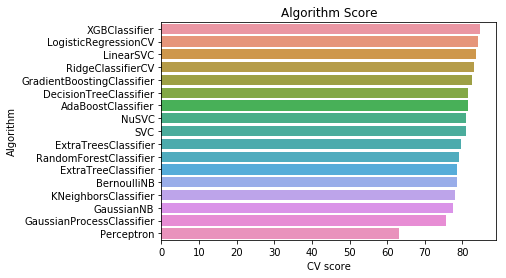

In [216]:
g = sns.barplot('cv score', 'Algorithm', data=algorithms)
g.set_xlabel('CV score')
g.set_title('Algorithm Score')

In [220]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10)

In [222]:
XGB = XGBClassifier()
xgb_param = {
    'loss' : ['deviance'],
    'n_estimators' : [100, 200, 300],
    'learning_rate' : [0.5, 0.1, 0.05, 0.01],
    'max_depth' : [4, 8],
    'min_sample_leaf' : [50, 100, 150],
    'max_features' : [0.3, 0.1]
    }

gsXGB = GridSearchCV(XGB, param_grid = xgb_param, cv = kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsXGB.fit(X_train, Y_train)
XGB_best = gsXGB.best_estimator_

gsXGB.best_score_

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  47 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done 960 out of 960 | elapsed:   27.2s finished


0.7971631205673759

In [225]:
svc = svm.SVC(probability=True)
svc_param = {
    'C' : [0.1, 1, 10, 50, 100, 200, 500, 1000],
    'kernel' : ['rbf'],
    'gamma' : [0.001, 0.01, 0.1, 1]
    }

gsSVC = GridSearchCV(svc, param_grid=svc_param, cv=kfold, scoring='accuracy', n_jobs=4, verbose=3)
gsSVC.fit(X_train, Y_train)
SVC_best = gsSVC.best_estimator_
gsSVC.best_score_

Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 136 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 320 out of 320 | elapsed:    4.6s finished


0.8014184397163121

In [231]:
GB = ensemble.GradientBoostingClassifier()
gb_param = {
    'loss' : ['deviance'],
    'learning_rate' : [0.1, 0.05, 0.01],
    'n_estimators' : [100, 200, 300],
    'max_depth' : [4, 8],
    'min_samples_leaf' : [100, 150],
    'max_features' : [0.3, 0.1],
    }
gsGB = GridSearchCV(GB, param_grid=gb_param, cv=kfold, scoring='accuracy', n_jobs=4, verbose=3)
gsGB.fit(X_train, Y_train)
gsGB_best = gsGB.best_estimator_
gsGB.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 380 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   10.2s finished


0.7815602836879433

In [233]:
vc = ensemble.VotingClassifier(
    estimators = [('xgb', XGB_best), ('SVC', SVC_best), ('gbc', gsGB_best)],
    voting='soft', n_jobs=4)

In [234]:
vc = vc.fit(X_train, Y_train)
pred = vc.predict(X_test)
acc = accuracy_score(Y_test, pred)
f1 = f1_score(Y_test, pred)
cv = cross_val_score(vc, X_test, Y_test).mean()

print('Accuracy:', round(acc*100, 2), 'f1:', round(f1*100, 2), 'cv:', round(cv*100, 2))

Accuracy: 85.88 f1: 78.63 cv: 81.4


In [242]:
ada = ensemble.AdaBoostClassifier()
ada_params = {
    'n_estimators' : [100, 200,300],
    'learning_rate' : [1, 0.1, 0.01],
    }
gsada = GridSearchCV(ada, param_grid=ada_params, cv =kfold, n_jobs=4, verbose=3)
gsada.fit(X_train, Y_train)
ada_best = gsada.best_estimator_
gsada.best_score_

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:    5.3s finished


0.7773049645390071

In [243]:
ada_best

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.01, n_estimators=300, random_state=None)

In [244]:
lg = linear_model.LogisticRegressionCV()
lg.fit(X_train, Y_train)

vc2 = ensemble.VotingClassifier(
    estimators = [('ada', ada_best), ('lg', lg), ('VotingClassifier', vc)],
    voting='soft', n_jobs=4)
vc2.fit(X_train, Y_train)

VotingClassifier(estimators=[('ada', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.01, n_estimators=300, random_state=None)), ('lg', LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
     ...se=0, warm_start=False))],
         flatten_transform=None, n_jobs=4, voting='soft', weights=None))],
         flatten_transform=None, n_jobs=4, voting='soft', weights=None)

In [245]:
pred = vc2.predict(X_test)
acc = accuracy_score(Y_test, pred)
f1 = f1_score(Y_test, pred)
cv = cross_val_score(vc2, X_test, Y_test).mean()
print('acc:', acc, 'f1:',f1, 'cv:', cv)

acc: 0.864406779661017 f1: 0.7966101694915255 cv: 0.8475225664004157


In [250]:
y_scores = vc2.predict_proba(X_test)
y_scores = y_scores[:, 1]

In [252]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, y_scores)

In [253]:
false_positive_rate

array([0.        , 0.00869565, 0.00869565, 0.00869565, 0.00869565,
       0.00869565, 0.00869565, 0.0173913 , 0.0173913 , 0.0173913 ,
       0.02608696, 0.03478261, 0.03478261, 0.06956522, 0.06956522,
       0.07826087, 0.07826087, 0.10434783, 0.13043478, 0.16521739,
       0.17391304, 0.1826087 , 0.1826087 , 0.19130435, 0.20869565,
       0.20869565, 0.22608696, 0.25217391, 0.26086957, 0.26086957,
       0.26956522, 0.28695652, 0.31304348, 0.31304348, 0.4       ,
       0.40869565, 0.44347826, 0.46086957, 0.48695652, 0.96521739,
       0.99130435, 1.        ])

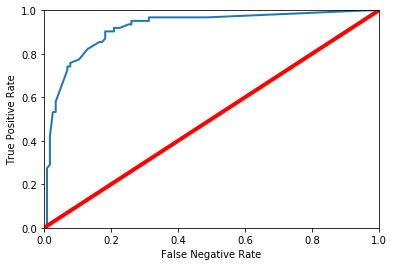

In [254]:
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, label=label, linewidth=2)
    plt.plot([0,1], [0,1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Negative Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(false_positive_rate, true_positive_rate)

In [256]:
auroc = roc_auc_score(Y_test, y_scores)
auroc

0.9204768583450211

In [269]:
pred = vc2.predict(test).astype(int)
pred


array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [270]:
target = pd.Series(pred, name='Survived')
output = pd.concat({'PassengerID':Id, 'Survived':target}, axis='columns')
output.to_csv('submission.csv', index=False, header=True)